<a href="https://colab.research.google.com/github/z-tufekci/DeepLearning/blob/main/MidTerm_ChestXray_CovidDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kaggle
!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pranavraikokte/covid19-image-dataset
!unzip covid19-image-dataset.zip
!ls /content/Covid19-dataset/train  #3 classes Covid	 Normal  'Viral Pneumonia'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 153M/158M [00:06<00:00, 21.8MB/s]
100% 158M/158M [00:06<00:00, 24.3MB/s]
Archive:  covid19-image-dataset.zip
  inflating: Covid19-dataset/test/Covid/0100.jpeg  
  inflating: Covid19-dataset/test/Covid/0102.jpeg  
  inflating: Covid19-dataset/test/Covid/0105.png  
  inflating: Covid19-dataset/test/Covid/0106.jpeg  
  inflating: Covid19-dataset/test/Covid/0108.jpeg  
  inflating: Covid19-dataset/test/Covid/0111.jpg  
  inflating: Covid19-dataset/test/Covid/0112.jpg  
  inflating: Covid19-dataset/test/Covid/0113.jpg  
  inflating: Covid19-dataset/test/Covid/0115.jpeg  
  inflating: Covid19-dataset/test/Covid/0118.jpeg  
  inflating: Covid19-dataset/test/Covid/0119.jpeg  
  inflating: Covid19-dataset/test/Covid/0120.jpg  
  inflating: Covid19-dataset/test/Covid/094.png  
  inflating: Covid19-dataset/test/Covid/096.png  
  inflating: Covid19-dataset/test/Covid/098.jpeg  
  inflating: Covid19-dataset/test/Covid/COVID-00003b.jpg

In [5]:
import tensorflow as tf
batch_size = 32
img_height = 224
img_width = 224
num_classes = 3 # len(class_names)
epochs = 100
data_augmentation = True

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.2)
val_datagen = ImageDataGenerator(validation_split=0.2)

src_path_train = "/content/Covid19-dataset/train"

train_generator = datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = val_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

input_shape = train_generator.image_shape

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [7]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
from math import ceil
from keras.utils import np_utils


In [24]:
!pip install tensorflow-addons
from tensorflow_addons.optimizers import AdamW

In [8]:
def lr_schedule(epoch):  
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 55:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

## 🛬  RESNET  ☕

In [27]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same', #We want to maintain the shape same during block
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    print(" activation: ", activation," bn: ", batch_normalization," kernelsize: ", kernel_size," stri ", strides,"  number of filters",num_filters)
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [28]:
def resnet_v1(input_shape, depth, num_classes=3):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    
    inputs = Input(shape=input_shape)
    #print("FIRST CNN LAYER")
    x = resnet_layer(inputs=inputs) # CONV2D
    for stack in range(3):    # STACK=3  18*3=54
       #print("STACK",stack+1)
       for res_block in range(num_res_blocks): # BLOCK=9  2*9=18
            strides = 1

            if stack > 0 and res_block == 0:
                strides = 2
                #print("--DOWNSAMPLING--") 
            
            #print("   BLOCK ",res_block+1)
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)

            if stack > 0 and res_block == 0: 
                #print("1x1 KERNEL APPLIED TO RESIDUAL BEFORE CONCAT")
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            #print("--CONCATENATE--")
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
            #print("END OF BLOCK" )
       #print("num_filters x 2")     
       num_filters *= 2
       #print("END OF STACK" )
    #print("AVERAGE POOLING AT THE END" ) 
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
   
    model = Model(inputs=inputs, outputs=outputs)
    return model  

In [29]:
def resnet_v2(input_shape, depth, num_classes=3):

    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')

    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    for stage in range(3): 
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                print("KERNEL SIZE 1")
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [30]:
n = 6 # block number
version = 2
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)
print(model_type)

ResNet56v2


In [ ]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth, num_classes=num_classes)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth, num_classes=num_classes)

## ❓ ❤ VGG MODEL ❓ ❤

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=input_shape), 
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

## ⛸ ⌨ MobileNetV2 ⌨ ♻

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               input_tensor=None,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


## ⚡  ❕ EfficientNetB2  👀 ⚡ 

In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape
)

31801344/31790344 [==============================] - 0s 0us/step


## ☕ DENSE NET ☕

In [10]:
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape
)

29097984/29084464 [==============================] - 1s 0us/step


## 🥇 INCEPTION RESNET 🥇

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
)

## ✨ NASNet ✨

In [ ]:
base_model = tf.keras.applications.NASNetLarge(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
)

## Common Code

In [13]:
base_model.trainable = False

for image_batch, label_batch in train_generator:
   break

feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

fully_connected_layer = tf.keras.layers.Dense(128, activation='relu')
fully_connected = fully_connected_layer(feature_batch_average)

prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(fully_connected)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  fully_connected_layer,
  prediction_layer
])

In [14]:
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=3,
                               min_lr=0.5e-6)
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')

callbacks = [lr_reducer, lr_scheduler]

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)), #AdamW(weight_decay=1e-4, lr=lr_schedule(0)
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(train_generator,                                                         
             validation_data=valid_generator,                                                      
             epochs=epochs, steps_per_epoch = train_generator.n//train_generator.batch_size ,
             batch_size=batch_size,
             shuffle=True,
             callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    history = model.fit_generator(train_generator,                                                         
                        validation_data=valid_generator,                                                       
                        epochs=epochs,
                        steps_per_epoch = train_generator.n//train_generator.batch_size , # bs=32 & n=201 201/32=6
                        callbacks=callbacks)

Learning rate:  0.001
Using real-time data augmentation.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Learning rate:  0.001
Epoch 1/100
6/6 [==============================] - 22s 3s/step - loss: 1.1131 - accuracy: 0.4970 - val_loss: 0.9131 - val_accuracy: 0.5000 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
6/6 [==============================] - 12s 2s/step - loss: 0.6094 - accuracy: 0.7574 - val_loss: 1.2745 - val_accuracy: 0.4400 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
6/6 [==============================] - 12s 2s/step - loss: 0.6184 - accuracy: 0.7574 - val_loss: 0.7434 - val_accuracy: 0.6000 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
6/6 [==============================] - 12s 2s/step - loss: 0.4271 - accuracy: 0.8047 - val_loss: 1.1568 - val_accuracy: 0.4200 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
6/6 [==============================] - 13s 2s/step - loss: 0.3951 - accuracy: 0.8490 - val_loss: 0.6570 - val_accuracy: 0.7400 - lr: 0.0010
Learning rate:  0.001
Epoch 6/100
6/6 [==============================] - 12s 2s/step - loss: 0.3818 - accuracy: 0.8580 - val_loss:

In [16]:
from keras.preprocessing.image import ImageDataGenerator

src_path_test = "/content/Covid19-dataset/test"
test_datagen = ImageDataGenerator() 
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)
#print(test_generator.labels)
#print(test_generator.filenames)

Found 66 images belonging to 3 classes.


In [17]:
scores = model.evaluate(test_generator, verbose=3)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.2690223753452301
Test accuracy: 0.8787878751754761


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


3/3 [==============================] - 2s 499ms/step
Reality: Covid
Predicted: Covid


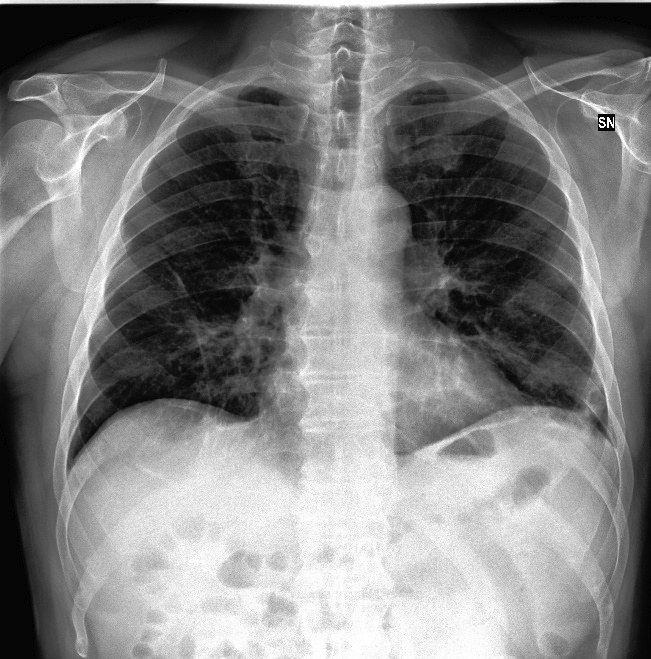

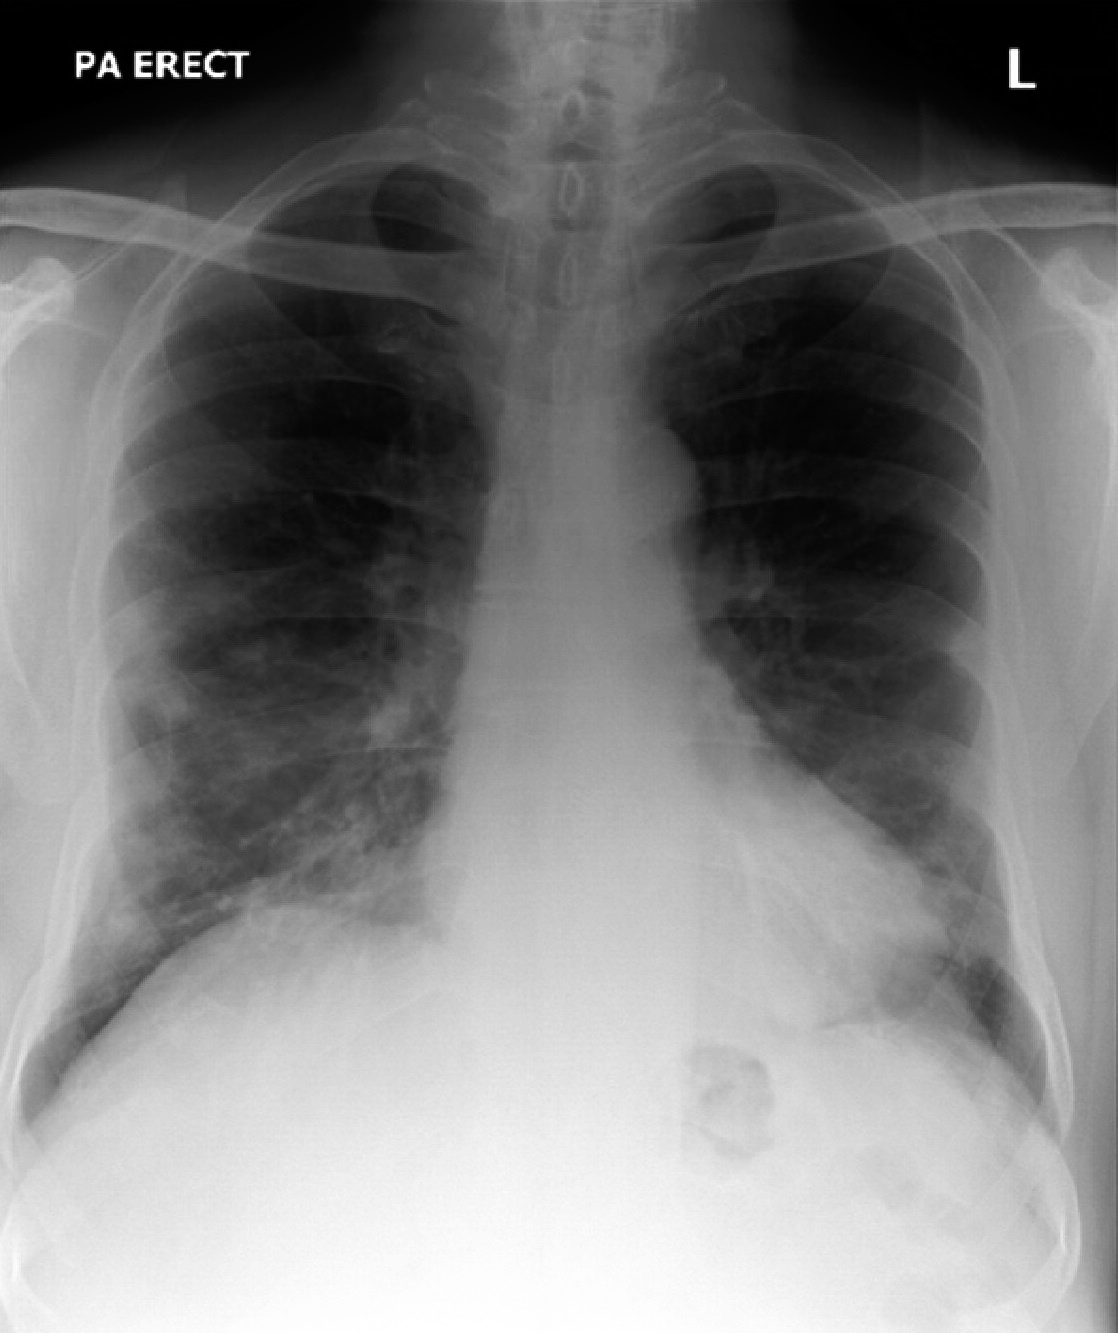

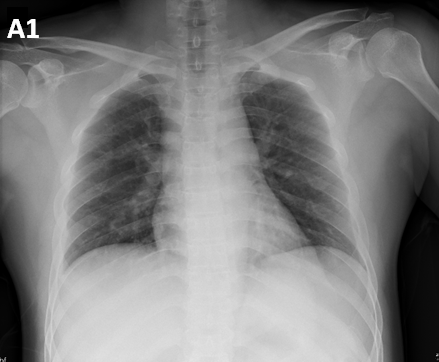


Reality: Covid
Predicted: Covid

Reality: Covid
Predicted: Covid

3


In [18]:
test_generator.reset()
# Predict 
pred=model.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

#print("Real: ",test_generator.labels)
#print("Predict: ",predicted_class_indices)

src_path_test = "/content/Covid19-dataset/test/"
from IPython.display import Image
i=0
count=0
stopIndex = 3
for filename, label in zip(test_generator.filenames, test_generator.labels):
    predict = predicted_class_indices[i]
    print("Reality:" ,("Covid" if label == 0 else ("Normal" if label == 1 else "Viral Pneumonia")))
    print("Predicted:" ,("Covid" if predict == 0 else ("Normal" if predict == 1 else "Viral Pneumonia")))
    display(Image(filename=src_path_test+filename,width=250, height=250))
    if predict == label:
        count += 1
    i += 1
    print()
    if i == stopIndex:
      break
print(count)

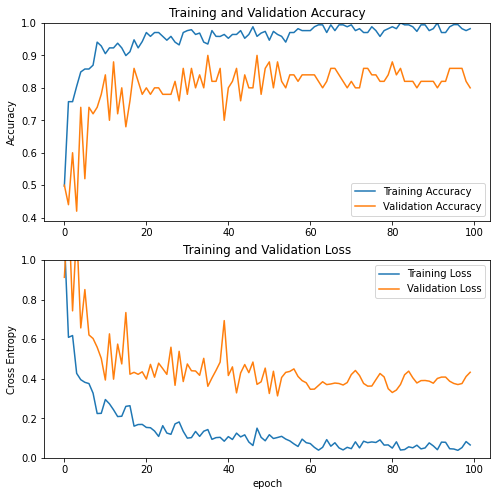

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()